# Final Capstone - Generative Adversarial Network (GAN)

The problem I am attempting to solve is the privacy concern a user might have when wanting to upload an image of himself or herself to the Internet, but the image includes other individuals.

I am proposing to use artificial human faces to replace real human faces in a user's picture before uploading it to the Internet. A few of the potential benefits:
- Removes / limits privacy concern a user might have about using images of himself or herself with other individuals.
- In addition to manual image manipulation, it provides an automated option for manipulating images.
- After the image has undergone a transformation, the user could use the image for a profile picture on social networking platforms or the image could be used on a platform where users are looking to meet new people. If the user selected all faces in the image to be replaced, it could be used as a family avatar or an avatar for a special group of friends or as a profile picture for a platform where the user wants to remain anonymous.

Potential application:
- Profile picture on social networking platforms.
- Profile picture on platform where the user wants to remain anonymous.
- Platform where users are looking to meet new people.
- Could be used by groups of friends or family members to generate amusing and entertaining avatars.

My dataset will contain images of faces retrieved by scraping https://thispersondoesnotexist.com. Each image will have an associated label: 0 for male and 1 for female.

I then plan to use these labeled images to train a Convolutional Neural Network to identify / classify gender in images and depending on the outcome of this CNN either a GAN that generates female faces will be used or a GAN that generates male faces will be used.

In [ ]:
# Install selenium and chromedriver for web scraping
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

     |████████████████████████████████| 911kB 4.5MB/s 
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [93.7 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates 

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
import json
import requests
import os
import sys
import time
import random
import warnings
import itertools
from google.colab import drive
from google.colab.patches import cv2_imshow
from bs4 import BeautifulSoup
from selenium import webdriver
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from keras.optimizers import Adam
from keras import backend as K
from IPython import display

# Display preference
%matplotlib inline
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Web Scraper

In [ ]:
thispersondoesnotexist_directory = '../gdrive/My Drive/colab/gan/thispersondoesnotexist/'

In [ ]:
# Header to accompany get request
headers = {'user-agent': 'scraper - school project (bengriffith@outlook.com)'}

# Retrieve faces
for i in range(1, 3001):
    with open(thispersondoesnotexist_directory + str(i) + '.png', 'wb') as f:
        response = requests.get('https://thispersondoesnotexist.com/image', headers=headers, timeout=15).content            
        f.write(response)

    time.sleep(5)

## Gender Convolutional Neural Network (CNN)

In [ ]:
# List for image data
image_data = []

# List to store detected face
data = []

# List to store labels
labels = []

In [ ]:
# Counter
images_processed = 0

# Populate image_data list
for filename in sorted(os.listdir(thispersondoesnotexist_directory)):
    image_path = thispersondoesnotexist_directory + filename
    image = cv2.imread(image_path)[:,:,::-1] # Convert to RGB
    image = cv2.resize(image, (64, 64))
    image_data.append([image, int(filename[filename.find('.') - 1])]) 
    images_processed += 1

print('There were {} images processed'.format(images_processed))

There were 2810 images processed


In [ ]:
# Separate image data into data list and labels list
for image in image_data:
    data.append(image[0])
    labels.append(image[1])

print('There are {} elements in data'.format(len(data)))
print('There are {} elements in labels'.format(len(labels)))

There are 2810 elements in data
There are 2810 elements in labels


In [ ]:
# Convert data and labels lists to numpy arrays
data = np.array(data, dtype='float') / 255.0 # Normalize images from 0 to 1
labels = np.array(labels)

In [ ]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20)

In [ ]:
print('There are {} records in the train dataset'.format(X_train.shape[0]))
print('There are {} records in the test dataset'.format(X_test.shape[0]))

There are 2248 records in the train dataset
There are 562 records in the test dataset


### Gender CNN Model Selection

```model_1``` , ```model_2```, ```model_3```, ```model_4``` and ```model_5``` functions are used to create different CNN models to be compared.

In [ ]:
def model_1(height, width, depth, num_classes):
    model = tf.keras.Sequential()
    input_shape = (height, width, depth)
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='sigmoid'))
    
    return model

In [ ]:
def model_2(height, width, depth, num_classes):
    model = tf.keras.Sequential()
    input_shape = (height, width, depth)
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    return model

In [ ]:
def model_3(height, width, depth, num_classes):
    model = tf.keras.Sequential()
    input_shape = (height, width, depth)

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.30))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.30))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    return model

In [ ]:
def model_4(height, width, depth, num_classes):
    model = tf.keras.Sequential()
    input_shape = (height, width, depth)

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    return model

In [ ]:
def model_5(height, width, depth, num_classes):
    model = tf.keras.Sequential()
    input_shape = (height, width, depth)

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='sigmoid'))

    return model

For CNN, define ```epochs```, ```batch_size```, ```patience``` and ```image_dimensions```.

In [ ]:
epochs = 100
batch_size = 32
patience = 25
image_dimensions = (64, 64, 3)

#### Model 1

Initialize, compile and train ```gender_model_1```.

In [ ]:
gender_model_1 = model_1(image_dimensions[0], image_dimensions[1], image_dimensions[2], 1)

In [ ]:
gender_model_1.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
es_1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
mc_1 = tf.keras.callbacks.ModelCheckpoint('../gdrive/My Drive/colab/gan/supporting/gender_model1.h5', 
                                          monitor='val_loss', 
                                          mode='min', verbose=1, save_best_only=True)

In [ ]:
gender_1 = gender_model_1.fit(X_train, y_train, batch_size=batch_size, 
                              validation_data=(X_test, y_test), 
                              epochs=epochs, 
                              verbose=0,
                              callbacks=[es_1, mc_1])


Epoch 00001: val_loss improved from inf to 0.37224, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model1.h5

Epoch 00002: val_loss improved from 0.37224 to 0.34535, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model1.h5

Epoch 00003: val_loss improved from 0.34535 to 0.33310, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model1.h5

Epoch 00004: val_loss improved from 0.33310 to 0.30213, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model1.h5

Epoch 00005: val_loss did not improve from 0.30213

Epoch 00006: val_loss did not improve from 0.30213

Epoch 00007: val_loss did not improve from 0.30213

Epoch 00008: val_loss did not improve from 0.30213

Epoch 00009: val_loss did not improve from 0.30213

Epoch 00010: val_loss did not improve from 0.30213

Epoch 00011: val_loss did not improve from 0.30213

Epoch 00012: val_loss did not improve from 0.30213

Epoch 00013: val_loss did not improve from 0.30213

Epoch 00014: va

In [ ]:
best_gender_model_1 = tf.keras.models.load_model('../gdrive/My Drive/colab/gan/supporting/gender_model1.h5')
score_1 = best_gender_model_1.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_1[1])

Test accuracy: 0.8896797299385071


#### Model 2

Initialize, compile and train ```gender_model_2```.

In [ ]:
gender_model_2 = model_2(image_dimensions[0], image_dimensions[1], image_dimensions[2], 1)

In [ ]:
gender_model_2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
es_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
mc_2 = tf.keras.callbacks.ModelCheckpoint('../gdrive/My Drive/colab/gan/supporting/gender_model2.h5', 
                                          monitor='val_loss', 
                                          mode='min', verbose=1, save_best_only=True)

In [ ]:
gender_2 = gender_model_2.fit(X_train, y_train, batch_size=batch_size, 
                              validation_data=(X_test, y_test), 
                              epochs=epochs, 
                              verbose=0,
                              callbacks=[es_2, mc_2])


Epoch 00001: val_loss improved from inf to 0.49506, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model2.h5

Epoch 00002: val_loss did not improve from 0.49506

Epoch 00003: val_loss improved from 0.49506 to 0.38458, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model2.h5

Epoch 00004: val_loss improved from 0.38458 to 0.30830, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model2.h5

Epoch 00005: val_loss improved from 0.30830 to 0.30098, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model2.h5

Epoch 00006: val_loss improved from 0.30098 to 0.29252, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model2.h5

Epoch 00007: val_loss improved from 0.29252 to 0.27806, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model2.h5

Epoch 00008: val_loss did not improve from 0.27806

Epoch 00009: val_loss did not improve from 0.27806

Epoch 00010: val_loss did not improve from 0.27806

Epoch 00011: va

In [ ]:
best_gender_model_2 = tf.keras.models.load_model('../gdrive/My Drive/colab/gan/supporting/gender_model2.h5')
score_2 = best_gender_model_2.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_2[1])

Test accuracy: 0.9039145708084106


#### Model 3

Initialize, compile and train ```gender_model_3```.

In [ ]:
gender_model_3 = model_3(image_dimensions[0], image_dimensions[1], image_dimensions[2], 1)

In [ ]:
gender_model_3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
es_3 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
mc_3 = tf.keras.callbacks.ModelCheckpoint('../gdrive/My Drive/colab/gan/supporting/gender_model3.h5', 
                                          monitor='val_loss', 
                                          mode='min', verbose=1, save_best_only=True)

In [ ]:
gender_3 = gender_model_3.fit(X_train, y_train, batch_size=batch_size, 
                              validation_data=(X_test, y_test), 
                              epochs=epochs, 
                              verbose=0,
                              callbacks=[es_3, mc_3])


Epoch 00001: val_loss improved from inf to 2.73644, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model3.h5

Epoch 00002: val_loss improved from 2.73644 to 1.30295, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model3.h5

Epoch 00003: val_loss improved from 1.30295 to 1.10295, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model3.h5

Epoch 00004: val_loss improved from 1.10295 to 0.80124, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model3.h5

Epoch 00005: val_loss did not improve from 0.80124

Epoch 00006: val_loss improved from 0.80124 to 0.68141, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model3.h5

Epoch 00007: val_loss improved from 0.68141 to 0.37707, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model3.h5

Epoch 00008: val_loss did not improve from 0.37707

Epoch 00009: val_loss did not improve from 0.37707

Epoch 00010: val_loss did not improve from 0.37707

Epoch 00011: va

In [ ]:
best_gender_model_3 = tf.keras.models.load_model('../gdrive/My Drive/colab/gan/supporting/gender_model3.h5')
score_3 = best_gender_model_3.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_3[1])

Test accuracy: 0.8594306111335754


#### Model 4

Initialize, compile and train ```gender_model_4```.

In [ ]:
gender_model_4 = model_4(image_dimensions[0], image_dimensions[1], image_dimensions[2], 1)

In [ ]:
gender_model_4.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
es_4 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
mc_4 = tf.keras.callbacks.ModelCheckpoint('../gdrive/My Drive/colab/gan/supporting/gender_model4.h5', 
                                          monitor='val_loss', 
                                          mode='min', verbose=1, save_best_only=True)

In [ ]:
gender_4 = gender_model_4.fit(X_train, y_train, batch_size=batch_size, 
                              validation_data=(X_test, y_test), 
                              epochs=epochs, 
                              verbose=0,
                              callbacks=[es_4, mc_4])


Epoch 00001: val_loss improved from inf to 0.99160, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model4.h5

Epoch 00002: val_loss improved from 0.99160 to 0.64040, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model4.h5

Epoch 00003: val_loss improved from 0.64040 to 0.53489, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model4.h5

Epoch 00004: val_loss improved from 0.53489 to 0.47184, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model4.h5

Epoch 00005: val_loss did not improve from 0.47184

Epoch 00006: val_loss did not improve from 0.47184

Epoch 00007: val_loss did not improve from 0.47184

Epoch 00008: val_loss improved from 0.47184 to 0.36072, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model4.h5

Epoch 00009: val_loss improved from 0.36072 to 0.29871, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model4.h5

Epoch 00010: val_loss did not improve from 0.29871

Epoch 00011: va

In [ ]:
best_gender_model_4 = tf.keras.models.load_model('../gdrive/My Drive/colab/gan/supporting/gender_model4.h5')
score_4 = best_gender_model_4.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_4[1])

Test accuracy: 0.8790035843849182


#### Model 5

Initialize, compile and train ```gender_model_5```.

In [ ]:
gender_model_5 = model_5(image_dimensions[0], image_dimensions[1], image_dimensions[2], 1)

In [ ]:
gender_model_5.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
es_5 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
mc_5 = tf.keras.callbacks.ModelCheckpoint('../gdrive/My Drive/colab/gan/supporting/gender_model5.h5', 
                                          monitor='val_loss', 
                                          mode='min', verbose=1, save_best_only=True)

In [ ]:
gender_5 = gender_model_5.fit(X_train, y_train, batch_size=batch_size, 
                              validation_data=(X_test, y_test), 
                              epochs=epochs, 
                              verbose=0,
                              callbacks=[es_5, mc_5])


Epoch 00001: val_loss improved from inf to 1.08002, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model5.h5

Epoch 00002: val_loss improved from 1.08002 to 0.95942, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model5.h5

Epoch 00003: val_loss improved from 0.95942 to 0.91137, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model5.h5

Epoch 00004: val_loss improved from 0.91137 to 0.81220, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model5.h5

Epoch 00005: val_loss improved from 0.81220 to 0.45300, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model5.h5

Epoch 00006: val_loss improved from 0.45300 to 0.34210, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model5.h5

Epoch 00007: val_loss improved from 0.34210 to 0.32920, saving model to ../gdrive/My Drive/colab/gan/supporting/gender_model5.h5

Epoch 00008: val_loss improved from 0.32920 to 0.32277, saving model to ../gdrive/My Drive/co

In [ ]:
best_gender_model_5 = tf.keras.models.load_model('../gdrive/My Drive/colab/gan/supporting/gender_model5.h5')
score_5 = best_gender_model_5.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', score_5[1])

Test accuracy: 0.8932384252548218


#### Model Selection

Model | Test Accuracy
------|--------------
```best_gender_model_1``` | 0.890
```best_gender_model_2``` | 0.903
```best_gender_model_3``` | 0.859
```best_gender_model_4``` | 0.879
```best_gender_model_5``` | 0.893


### Gender CNN Model Evaluation


In [ ]:
# CNN predictions
predictions = best_gender_model_2.predict_classes(X_test, batch_size=32)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


#### Classification Report

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       246
           1       0.91      0.91      0.91       316

    accuracy                           0.90       562
   macro avg       0.90      0.90      0.90       562
weighted avg       0.90      0.90      0.90       562



#### Confusion Matrix

In order to generate a nice visualization for the confusion matrix, I am using the following function taken from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix.

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

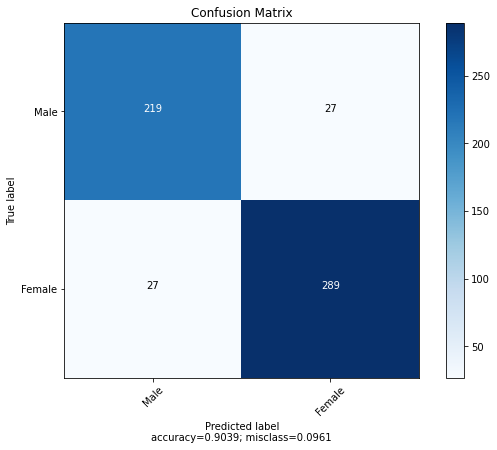

In [ ]:
confusion = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm=confusion, target_names = ['Male', 'Female'], title = 'Confusion Matrix', normalize=False)

#### Receiver Operating Characteristic Curve (ROC) and Area Under the Curve (AUC)

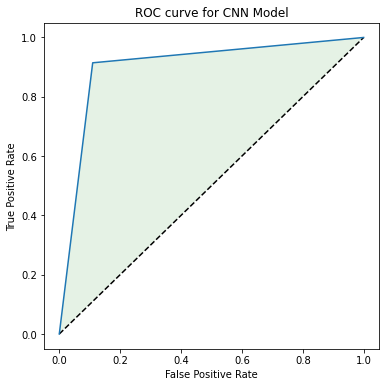

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.fill(fpr, tpr, 'green', alpha=0.1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for CNN Model')
plt.show()

In [ ]:
auc = roc_auc_score(y_test, predictions)
print('Area under the ROC curve: {:.3f}'.format(auc))

Area under the ROC curve: 0.902


#### Training / Validation Loss and Accuracy

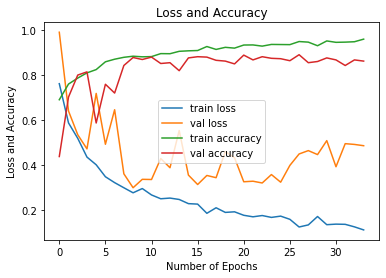

In [ ]:
# Plot loss and accuracy
epoch_range = np.arange(0, 34)
plt.figure()
plt.plot(epoch_range, gender_4.history['loss'], label='train loss')
plt.plot(epoch_range, gender_4.history['val_loss'], label='val loss')
plt.plot(epoch_range, gender_4.history['accuracy'], label='train accuracy')
plt.plot(epoch_range, gender_4.history['val_accuracy'], label='val accuracy')
plt.title('Loss and Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss and Accuracy')
plt.legend()
plt.show()

## Generative Adversarial Network

In order to replace real human faces with artificial faces in user images, a GAN will be implemented. Throughout the implementation below, I referenced the Deep Convolutional GAN tutorial from TensorFlow's website (https://www.tensorflow.org/tutorials/generative/dcgan).

In [ ]:
# Female images
image_females = []

# Male images
image_males = []

# Separate into female and male
for image in image_data:
    if image[1] == 1:
        image_females.append(image[0])
    else:
        image_males.append(image[0])

print('There are {} female images'.format(len(image_females)))
print('There are {} male images'.format(len(image_males)))

There are 1598 female images
There are 1212 male images


In [ ]:
# Convert image_females and image_males lists to numpy arrays
image_females = np.array(image_females, dtype='float32')
image_males = np.array(image_males, dtype='float32')

In [ ]:
# Normalize images to [-1, 1]
image_females = (image_females - 127.5) / 127.5
image_males = (image_males - 127.5) / 127.5

In [ ]:
female_buffer_size = len(image_females)
male_buffer_size = len(image_males)
batch_size = 32

In [ ]:
# Batch and shuffle the training dataset
train_female_dataset = tf.data.Dataset.from_tensor_slices(image_females).shuffle(female_buffer_size).batch(batch_size)
train_male_dataset = tf.data.Dataset.from_tensor_slices(image_males).shuffle(male_buffer_size).batch(batch_size)

```create_generator``` creates the generator model that learns to produce images that look real. The generator utilizes ```layers.Conv2DTranspose()``` layers to produce an image from random noise.

In [ ]:
def create_generator():
    generator = tf.keras.Sequential()
    init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)
    generator.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)))
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())

    generator.add(layers.Reshape((8, 8, 256)))
    assert generator.output_shape == (None, 8, 8, 256)

    generator.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', kernel_initializer=init, use_bias=False))
    assert generator.output_shape == (None, 8, 8, 256)
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())

    generator.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False))
    assert generator.output_shape == (None, 16, 16, 128)
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())

    generator.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', kernel_initializer=init, use_bias=False))
    assert generator.output_shape == (None, 16, 16, 64)
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())

    generator.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False))
    assert generator.output_shape == (None, 32, 32, 32)
    generator.add(layers.BatchNormalization())
    generator.add(layers.LeakyReLU())

    generator.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', kernel_initializer=init, use_bias=False, activation='tanh'))
    assert generator.output_shape == (None, 64, 64, 3)

    return generator

```create_discriminator``` creates the discriminator model that learns to tell real images apart from fakes. The discriminator is a CNN-based image classifier.

In [ ]:
def create_discriminator():
    discriminator = tf.keras.Sequential()
    discriminator.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.25))

    discriminator.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.25))

    discriminator.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    discriminator.add(layers.BatchNormalization())
    discriminator.add(layers.LeakyReLU(0.2))
    discriminator.add(layers.Dropout(0.3))

    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(1))

    return discriminator

In [ ]:
# Initialize generator and discriminator
male_generator = create_generator()
male_discriminator = create_discriminator()

female_generator = create_generator()
female_discriminator = create_discriminator()

The generator loss quantifies how well it was able to trick the discriminator. While the discriminator loss quantifies how well it is able to distinguish real images from fakes.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

In [ ]:
# Training
epochs = 200
noise_dim = 100
number_examples_to_generate = 4

seed = tf.random.normal([number_examples_to_generate, noise_dim])

In ```train_step```, the following sequence occurs:
1. The training loop begins with generator receiving a random seed as input, which is used to produce an image.
2. The discriminator is used to classify real images and fake images. 
3. The loss is calculated for the generator and discriminator.
4. The gradients are used to update the generator and discriminator.

In [ ]:
@tf.function
def train_step(images, generator_model, discriminator_model):

    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        
        generated_images = generator_model(noise, training=True)

        real_output = discriminator_model(images, training=True)
        fake_output = discriminator_model(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = generator_tape.gradient(gen_loss, generator_model.trainable_variables)
    gradients_of_discriminator = discriminator_tape.gradient(disc_loss, discriminator_model.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [ ]:
def train(dataset, epochs, generator_model, discriminator_model):

    for epoch in range(epochs):

        start = time.time()

        for image_batch in dataset:
            train_step(image_batch, generator_model, discriminator_model)

        display.clear_output(wait=True)
        generate_and_save_images(generator_model, epoch + 1, seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    display.clear_output(wait=True)
    generate_and_save_images(generator_model, epochs, seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):

    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

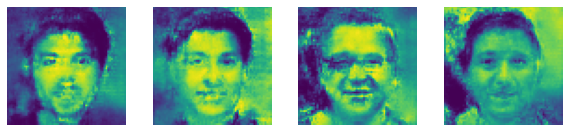

In [ ]:
# Train on male images
train(train_male_dataset, epochs, male_generator, male_discriminator)

In [ ]:
# Save male_generator to disk for future use
male_generator.save('../gdrive/My Drive/colab/gan/supporting/male_generator_model1.h5')

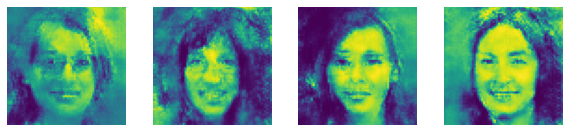

In [ ]:
# Train on female images
train(train_female_dataset, epochs, female_generator, female_discriminator)

In [ ]:
# Save female_generator to disk for future use
female_generator.save('../gdrive/My Drive/colab/gan/supporting/female_generator_model1.h5')

## CNN and GAN Test
- Load ```gender_model```, ```male_gan``` and ```female_gan```
- Test with 2 images by
  1. Predicting gender
  2. Compare predicted gender against actual gender
  3. Based on predicted gender, create artificial face (either male or female)

In [ ]:
# Load CNN gender classifier
gender_model = tf.keras.models.load_model('../gdrive/My Drive/colab/gan/supporting/gender_model2.h5')

# Load male generator
male_gan = tf.keras.models.load_model('../gdrive/My Drive/colab/gan/supporting/male_generator_model1.h5', compile=False)

# Load female generator
female_gan = tf.keras.models.load_model('../gdrive/My Drive/colab/gan/supporting/female_generator_model1.h5', compile=False)

In [ ]:
# Test image path
test_image_files = ['2152_0.png', '2199_1.png']
test_image_path = '../gdrive/My Drive/colab/gan/thispersondoesnotexist/'

plot_information = []

for test_image_file in test_image_files:

    # Test image path
    temp_dir = test_image_path + test_image_file

    # Load test image
    test_image = cv2.imread(temp_dir)
    test_image_copy = test_image.copy()

    # Test face image processing
    test_face_image = cv2.resize(test_image, (64, 64))[:,:,::-1] # Convert to RGB
    test_face_image_copy = test_face_image.copy()
    test_face_image = test_face_image.astype('float') / 255.0
    test_face_image = test_face_image.reshape((1, test_face_image.shape[0], test_face_image.shape[1], test_face_image.shape[2]))
    test_face_image_label = int(test_image_file[test_image_file.find('.') - 1])

    # Generate prediction
    test_image_prediction = gender_model.predict_classes(test_face_image)

    # Seed for GAN
    gan_seed = tf.random.normal([1, 100])

    if test_image_prediction[0][0] == 0:
        male_face = male_gan.predict(gan_seed)
        male_face = male_face[0, :, :]
        plot_information.append([test_face_image_label, test_image_prediction[0][0], 
                                 test_face_image_copy, male_face, test_image_copy])
                                 
    else:
        female_face = female_gan.predict(gan_seed)
        female_face = female_face[0, :, :]
        plot_information.append([test_face_image_label, test_image_prediction[0][0], 
                                 test_face_image_copy, female_face, test_image_copy])
                                 

```comparison``` is used to output Actual Value (Gender) and Predicted Value along with real face and artificial face.

In [ ]:
def comparison(index, sample):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    print('Test {}: Actual Value {} and Predicted Value {}'.format(str(sample), plot_information[index][0], plot_information[index][1]))
    ax1.imshow((plot_information[index][2] + 255).astype(np.uint8))
    ax1.set_title('Real Face')
    ax1.axis('off')
    ax2.imshow((plot_information[index][3] * 127.5 + 127.5).astype(np.uint8))
    ax2.set_title('Artificial Face')
    ax2.axis('off')

    plt.tight_layout()

#### Test 1

Test 1: Actual Value 0 and Predicted Value 0


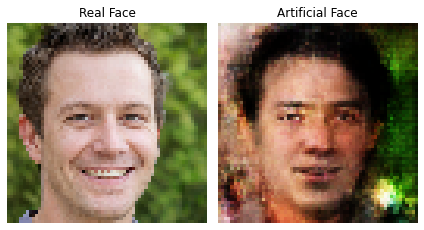

In [ ]:
comparison(0, 1)

#### Test 2

Test 2: Actual Value 1 and Predicted Value 1


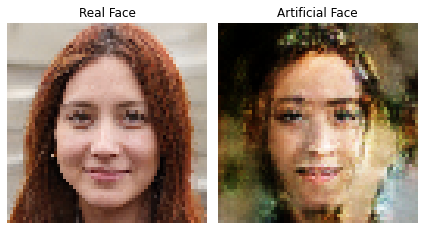

In [ ]:
comparison(1, 2)

# Final Thoughts

Throughout my project, I accomplished the following:

- Created a web scraper that successfully scraped images from thispersondoesnotexist.com for my dataset.
- Created a CNN gender classifier that detects male or female with 88% accuracy.
- Created two GANs: one for male artificial faces and one for female artificial faces.

Implementing the following enhancements could possibly achieve better results:

- More images would be beneficial especially for training of the GANs.
- Removal of potential duplicate images in the dataset.
- Implement different GAN architectures.
- Tuning for CNN and GANs.